In [ ]:

import numpy as np
from tensorflow.keras.layers import Add, Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import Activation, AveragePooling2D, Input, Flatten
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt   

In [ ]:
batch_size = 128
epochs = 60
n_classes = 10
learning_rate = 0.1

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

170498071/170498071 [==============================] - 7s 0us/step


In [ ]:
class Resnet:
    def __init__(self, size=44, stacks=3, starting_filter=16):
        self.size = size
        self.stacks = stacks
        self.starting_filter = starting_filter
        self.residual_blocks = (size - 2) // 6
        
    def get_model(self, input_shape=(32, 32, 3), n_classes=10):
        n_filters = self.starting_filter

        inputs = Input(shape=input_shape)
        network = self.layer(inputs, n_filters)
        network = self.stack(network, n_filters, True)

        for _ in range(self.stacks - 1):
            n_filters *= 2
            network = self.stack(network, n_filters)

        network = Activation('elu')(network)
        network = AveragePooling2D(pool_size=network.shape[1])(network)
        network = Flatten()(network)
        outputs = Dense(n_classes, activation='softmax', 
                        kernel_initializer='he_normal')(network)

        model = Model(inputs=inputs, outputs=outputs)

        return model
    
    def stack(self, inputs, n_filters, first_stack=False):
        stack = inputs

        if first_stack:
            stack = self.identity_block(stack, n_filters)
        else:
            stack = self.convolution_block(stack, n_filters)

        for _ in range(self.residual_blocks - 1):
            stack = self.identity_block(stack, n_filters)

        return stack
    
    def identity_block(self, inputs, n_filters):
        shortcut = inputs

        block = self.layer(inputs, n_filters, normalize_batch=False)
        block = self.layer(block, n_filters, activation=None)

        block = Add()([shortcut, block])

        return block

    def convolution_block(self, inputs, n_filters, strides=2):
        shortcut = inputs

        block = self.layer(inputs, n_filters, strides=strides,
                           normalize_batch=False)
        block = self.layer(block, n_filters, activation=None)

        shortcut = self.layer(shortcut, n_filters,
                              kernel_size=1, strides=strides,
                              activation=None)

        block = Add()([shortcut, block])

        return block
    
    def layer(self, inputs, n_filters, kernel_size=3,
              strides=1, activation='elu', normalize_batch=True):
    
        convolution = Conv2D(n_filters, kernel_size=kernel_size,
                             strides=strides, padding='same',
                             kernel_initializer="he_normal",
                             kernel_regularizer=l2(1e-4))

        x = convolution(inputs)

        if normalize_batch:
            x = BatchNormalization()(x)

        if activation is not None:
            x = Activation(activation)(x)

        return x
    
def learning_rate_schedule(epoch):
    new_learning_rate = learning_rate

    if epoch <= 40:
        pass
    elif epoch > 40 and epoch <= 50:
        new_learning_rate = learning_rate * 0.1
    else:
        new_learning_rate = learning_rate * 0.01
        
    print('Learning rate:', new_learning_rate)
    
    return new_learning_rate

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

In [ ]:
resnet = Resnet()

model = resnet.get_model()

optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

In [ ]:
import keras

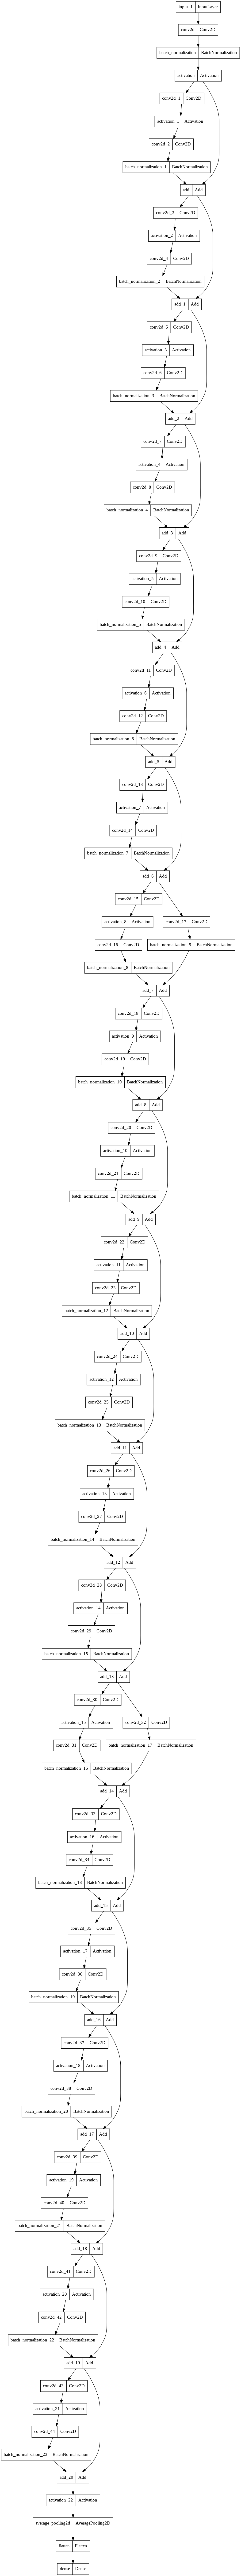

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
lr_scheduler = LearningRateScheduler(learning_rate_schedule)
callbacks = [lr_scheduler]

datagen = ImageDataGenerator(width_shift_range=4,
                             height_shift_range=4,
                             horizontal_flip=True,
                             preprocessing_function=get_random_eraser(p=1, pixel_level=True))
datagen.fit(x_train)

trained = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
          validation_data=(x_test, y_test),
          epochs=epochs, workers=4,
          callbacks=callbacks)

model.save('model.h5')

Learning rate: 0.1
Epoch 1/60
391/391 [==============================] - 57s 135ms/step - loss: 1.9821 - accuracy: 0.3983 - val_loss: 1.6714 - val_accuracy: 0.5109 - lr: 0.1000
Learning rate: 0.1
Epoch 2/60
391/391 [==============================] - 51s 131ms/step - loss: 1.5623 - accuracy: 0.5463 - val_loss: 1.3609 - val_accuracy: 0.6281 - lr: 0.1000
Learning rate: 0.1
Epoch 3/60
391/391 [==============================] - 51s 130ms/step - loss: 1.3296 - accuracy: 0.6333 - val_loss: 1.1491 - val_accuracy: 0.6937 - lr: 0.1000
Learning rate: 0.1
Epoch 4/60
391/391 [==============================] - 53s 135ms/step - loss: 1.1867 - accuracy: 0.6796 - val_loss: 1.2542 - val_accuracy: 0.6576 - lr: 0.1000
Learning rate: 0.1
Epoch 5/60
391/391 [==============================] - 50s 128ms/step - loss: 1.0890 - accuracy: 0.7132 - val_loss: 0.9471 - val_accuracy: 0.7608 - lr: 0.1000
Learning rate: 0.1
Epoch 6/60
391/391 [==============================] - 50s 126ms/step - loss: 1.0188 - accuracy: 

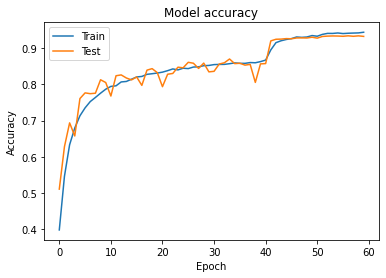

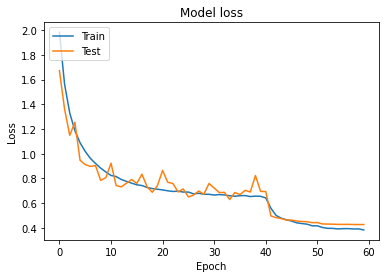

In [ ]:
plot.plot(trained.history['accuracy'])
plot.plot(trained.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [ ]:

# y_pred = model.predict_classes(X_test)
predict_y = model.predict(x_test) 
y_pred = np.argmax(predict_y,axis=1)
print(y_pred.shape)
print(y_test.shape)
y_test_1 = y_test.argmax(axis=1)
print(y_test_1.shape)

313/313 [==============================] - 3s 7ms/step
(10000,)
(10000, 10)
(10000,)


In [ ]:
print(y_pred[:10])
print(y_test_1[:10])

[3 8 1 8 6 6 1 6 3 1]
[3 8 8 0 6 6 1 6 3 1]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
print("Testing Accuracy: ", accuracy_score(y_test_1,y_pred))

Testing Accuracy:  0.9324


In [ ]:
cm = confusion_matrix(y_test_1, y_pred)
cm

array([[942,   4,  23,   3,   2,   1,   1,   2,  19,   3],
       [  5, 967,   0,   0,   0,   0,   1,   0,   1,  26],
       [ 12,   0, 918,  23,  15,   9,  14,   5,   3,   1],
       [  6,   0,  22, 849,  16,  75,  14,   9,   6,   3],
       [  5,   0,  11,  10, 946,   9,   4,  15,   0,   0],
       [  4,   1,   9,  69,  10, 894,   5,   8,   0,   0],
       [  3,   0,  15,  18,   3,   6, 952,   1,   1,   1],
       [  6,   0,   9,   6,  12,  12,   1, 954,   0,   0],
       [ 17,   9,   2,   2,   2,   0,   2,   1, 955,  10],
       [  7,  29,   2,   5,   0,   0,   0,   0,  10, 947]])

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Confusion matrix, without normalization


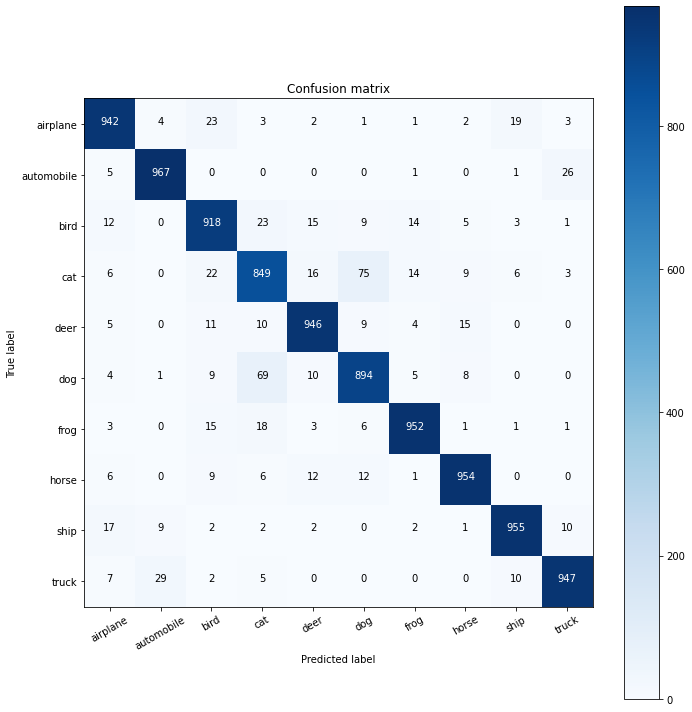

In [ ]:
plt.figure(figsize = (10,10))
plot_confusion_matrix(cm,classes)